In [3]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob, numpy as np, imp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sqlalchemy import create_engine
sn.set_context('notebook')

# TOC trends 2015: database clean-up (part 1)

My "to do" list for RESA2 following the meeting on 27/05/2016 is on the network here:

K:\Prosjekter\langtransporterte forurensninger\O-23300 - ICP-WATERS - HWI\Database\JamesS\RESA2_To_Do_HWI.docx

I want to start working through these items, prioritising stuff relating to the TOC trends analysis because I know I'm running a bit behind here. I also want to document my changes carefully as this is the first time I've modified the "live" version of RESA2, and I need to be able to undo things again in case I mess it all up. This notebook documents my workflow.

**NB for James:** Some of the code below modifies RESA2. It also documents what the database looked like *before* making any changes. **Do not** re-run this workbook without checking the code below first, as the results will change and you'll lose the record of what you've done. 

## 1. Connect Python to RESA2

As a first step, I'd like to try connecting Python directly to the Oracle database underlying RESA2. If this works, I should be able to interact with the database directly from my code (i.e. bypassing the RESA2 interface), which will make some of the steps below much easier. 

As a quick test, start by creating a connection and running a simple query against the database.

In [2]:
# Create connection

# Use custom RESA2 function to connect to db
r2_func_path = r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template\useful_resa2_code.py'
resa2 = imp.load_source('useful_resa2_code', r2_func_path)

engine, conn = resa2.connect_to_resa2()

# Test SQL statement
sql = ('SELECT project_id, project_number, project_name '
       'FROM resa2.projects')
df = pd.read_sql_query(sql, engine)

df.head(10)

,project_id,project_number,project_name
0,1130,None,FJORDA
1,2945,O 29010 06,Otra sidebekker
2,2965,O 29264 02,VRD-Telemark-B�rsesj�
3,1133,None,FLAGSTAD
4,1135,None,FLORID
5,1140,None,FROMLAB
6,1141,None,FROYSET
7,1142,None,GAULA
8,1143,None,GJELLESOGN
9,1144,None,GPVEST


Woohoo - that was much easier than expected! Right, on with the data cleaning, staring with the easiest stuff first...

## 2. Remove some of US sites from the analysis

The definitive list of US LTM sites to be included in the analysis is attached to John’s e-mail from 26/05/2016 at 16:35. After discussion with Tore, the best way to remove the unwanted sites is to create a new project called `XXX_US_LTM_EXCLUDED` and shift the sites marked `EXCLUDE` in John's spreadsheet over to that.

First, let's see how the US sites currently in the database compare to those in John's spreadsheet. Start by reading the spreadsheet.

In [3]:
# Read John's list of US sites
us_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters'
           r'\TOC_Trends_Analysis_2015\Data\US.sites.include.exclude.xlsx')
j_df = pd.read_excel(us_xlsx, sheetname='Sheet1')

print 'Total number of US sites in spreadsheet: %s.' % len(j_df)
j_df.head()

Total number of US sites in spreadsheet: 87.


,Station ID,Station Code,Station name,Latitude,Longitude,INC_EXC
0,23683,US48,"Willis Lake, Adirondacks",43.3714,-74.2463,EXCLUDE
1,23709,US74,"Mud Pond, Maine",44.6306,-65.0939,INCLUDE
2,36982,X15:020058O,LITTLE HOPE POND,44.5158,-74.1252,EXCLUDE
3,36983,X15:020059O,BIG HOPE POND,NaN,NaN,EXCLUDE
4,36984,X15:020138O,EAST COPPERAS POND,44.3119,-74.3722,INCLUDE


Next, a quick manual check in RESA2 shows that the `ICPW_TOCTRENDS_2015_US_LTM` project has `PROJECT_ID=3870`, so let's get the sites associated with that project from the database.

In [4]:
# Get the ICPW_TOCTRENDS_2015_US_LTM sites from RESA2
sql = ('SELECT * '
       'FROM resa2.projects_stations '
       'WHERE project_id = 3870')
r_df = pd.read_sql_query(sql, engine)

print 'Total number of US sites in RESA2: %s.' % len(r_df)
r_df.head()

Total number of US sites in RESA2: 90.


,station_id,project_id,active,station_code,station_name
0,36982,3870,Y,020058O,None
1,36983,3870,Y,020059O,None
2,36984,3870,Y,020138O,None
3,36985,3870,Y,020188E,None
4,36986,3870,Y,020197E,None


So there are **3 more sites in RESA2 than in John's spreadsheet** (and that's including the sites John would like removing). It looks as though the station IDs are compatible between the two datasets, so to try to work out what's going on we can match based on these columns and (hopefully) identify the 3 mystery sites.

In [5]:
all_df = pd.merge(r_df, j_df, how='left', 
                  left_on='station_id', right_on='Station ID')
all_df[pd.isnull(all_df['Station ID'])]

,station_id,project_id,active,station_code,station_name,Station ID,Station Code,Station name,Latitude,Longitude,INC_EXC
16,36999,3870,Y,040874O,None,NaN,NaN,NaN,NaN,NaN,NaN
44,37027,3870,Y,1A1-109O,None,NaN,NaN,NaN,NaN,NaN,NaN
45,37028,3870,Y,1A1-110O,None,NaN,NaN,NaN,NaN,NaN,NaN
64,37047,3870,Y,1C1-106,None,NaN,NaN,NaN,NaN,NaN,NaN
85,37070,3870,Y,ME-4474,None,NaN,NaN,NaN,NaN,NaN,NaN


Argh! There are *5 sites* in the table above, not 3. This implies that:

 1. There are sites in RESA2 that are not in John's spreadsheet, **and** <br><br>
 2. There are sites in John's spreadsheet that are not in RESA2.

Repeating the above code using an `outer join` rather then a `left join` should make this apparent.

In [6]:
all_df = pd.merge(r_df, j_df, how='outer', 
                  left_on='station_id', right_on='Station ID')
all_df[pd.isnull(all_df['Station ID']) | pd.isnull(all_df['station_id'])]

,station_id,project_id,active,station_code,station_name,Station ID,Station Code,Station name,Latitude,Longitude,INC_EXC
16,36999.0,3870.0,Y,040874O,None,NaN,NaN,NaN,NaN,NaN,NaN
44,37027.0,3870.0,Y,1A1-109O,None,NaN,NaN,NaN,NaN,NaN,NaN
45,37028.0,3870.0,Y,1A1-110O,None,NaN,NaN,NaN,NaN,NaN,NaN
64,37047.0,3870.0,Y,1C1-106,None,NaN,NaN,NaN,NaN,NaN,NaN
85,37070.0,3870.0,Y,ME-4474,None,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN,23683.0,US48,"Willis Lake, Adirondacks",43.3714,-74.2463,EXCLUDE
91,NaN,NaN,NaN,NaN,NaN,23709.0,US74,"Mud Pond, Maine",44.6306,-65.0939,INCLUDE


The first 5 rows of this table are sites that appear in RESA2, but which are not in John's spreadsheet; the last two rows appear in John's spreadsheet but are not in RESA2 (or, at least, they're not associated with the `ICPW_TOCTRENDS_2015_US_LTM` project). 

Decide to do the following:

 * Assume the 5 sites not mentioned in John's spreadsheet are not needed in the analysis, so **exclude** them from RESA2 along with the others marked for exclusion (**check this with John**). <br><br>
 
 * Add one new site (US74; Mud Pond, Maine) to the project (or database?). <br><br>
 
 * Do nothing for Willis Lake, Adirondacks, because John has it marked for exclusion anyway.

**NB:** There is *another* Mud Pond in both RESA2 and John's spreadsheet (station ID 37063; site code 1E1-134). This Mud Pond has an *almost* identical latitude to Mud Pond, Maine, but a significantly different longitude. I assume these really are two different sites, as specified in John's spreadsheet, but perhaps **double-check this with John too**. For reference, the two relevant entries from John's spreadsheet are:

| Station ID | Station Code |   Station name  | Latitude | Longitude | INC_EXC |
|:----------:|:------------:|:---------------:|:--------:|:---------:|:-------:|
| 23709      | US74         | Mud Pond, Maine | 44.6306  | -65.0939  | INCLUDE |
| 37063      | 1E1-134      | MUD POND        | 44.633   | -68.0908  | INCLUDE |

**NB2:** There is a Willis Lake already in RESA2, with exactly the same geographic co-ordinates as the Willis Lake, Adirondacks highlighted in the above table. John's spreadsheet actually contains two versions of this site as well (shown in the table below) and both have valid station IDs, so I guess he must have found it duplicated somewhere in RESA2.

| Station ID | Station Code |       Station name       | Latitude | Longitude | INC_EXC |
|:----------:|:------------:|:------------------------:|:--------:|:---------:|:-------:|
| 23683      | US48         | Willis Lake, Adirondacks | 43.3714  | -74.2463  | EXCLUDE |
| 37003      | 050215O      | WILLIS LAKE              | 43.3714  | -74.2463  | EXCLUDE |

Regardless, both these are marked as `EXCLUDE`, so as long as I make sure both are removed from the project in RESA2 everything should be OK.

### 2.1. Exclude sites

Following Tore's advice, I've created a new project in RESA2 called `ICPW_TOCTRENDS_2015_US_LTM_EXCLUDED`, which has project code 4150. I want to associate all the sites marked `EXCLUDE` in John's spreadsheet, plus the five sites listed above, with this new code. To do this, I first need a list of all the stations I want to move. In total, there should be 20 stations marked for exclusion (15 from John's spreadsheet and 5 from above), but as Willis Lake, Adirondacks (station code US48) is not currently linked to the project, I'm only expecting 19 matches from the database itself. Let's check.

In [7]:
# List of sites marked 'EXCLUDE' in John's spreadsheet
j_exc = j_df.query('INC_EXC == "EXCLUDE"')
j_exc_li = list(j_exc['Station ID'].values)

# List of sites already in RESA2 to exclude
r_exc = all_df[pd.isnull(all_df['Station ID'])]
r_exc_li = [int(i) for i in list(r_exc['station_id'].values)]

# Concatenate lists and convert to tuple
exc_tu = tuple(j_exc_li + r_exc_li)

# Extract matches from database
sql = ('SELECT * '
       'FROM resa2.projects_stations '
       'WHERE project_id = 3870 '
       'AND station_id IN %s' % str(exc_tu))

exc_df = pd.read_sql_query(sql, engine)

print 'Number of sites to exclude from US_LTM project: % s.' % len(exc_df)

exc_df

Number of sites to exclude from US_LTM project: 19.


,station_id,project_id,active,station_code,station_name
0,36982,3870,Y,020058O,None
1,36983,3870,Y,020059O,None
2,36999,3870,Y,040874O,None
3,37003,3870,Y,050215O,None
4,37027,3870,Y,1A1-109O,None
5,37028,3870,Y,1A1-110O,None
6,37041,3870,Y,1C1-094,None
7,37046,3870,Y,1C1-104,None
8,37047,3870,Y,1C1-106,None
9,37048,3870,Y,1C1-108,None


So far so good. The final step is to use an `update query` to change the project code for these sites from 3870 to 4150. **NB: This cannot be undone**, and you should only run this code once. It will also make changes to the database, so all the code above here will return different results if you run it again in the future.

In [9]:
# Move sites to EXCLUDED project
sql = ('UPDATE resa2.projects_stations '
       'SET project_id=4150 '
       'WHERE project_id = 3870 '
       'AND station_id IN %s' % str(exc_tu))
  
# Only run the code below when you're sure it's correct and you're
# finished with the code above!
result = conn.execute(sql)

Having made these changes, there should now be fewer sites associated with the `ICPW_TOCTRENDS_2015_US_LTM` project. There were originally 90 sites in RESA2 and we've just excluded 19, so there should be 71 left. John's spreadsheet has 72 US sites on the "include" list, but this is OK because we haven't yet added `Mud Pond, Maine` - that's the next step.

### 2.2. Add a new station

John's spreadsheet includes a `Station ID` for Mud Pond, Maine (23709), which I assume he got from RESA2, so perhaps the site *is* actually in the database after all, but simply not associated with the `ICPW_TOCTRENDS_2015_US_LTM` project. Let's check.

In [36]:
# Search all sites in RESA2 for site ID 23709
sql = ('SELECT * '
       'FROM resa2.stations '
       'WHERE station_id = 23709')
df = pd.read_sql_query(sql, engine)

df

,station_id,station_code,station_name,lake_or_river,lake_river_name,latitude,longitude,altitude,map_sheet,country_no,...,catchment_peat_area,catchment_water_area,station_description,entered_by,entered_date,blr,old_id,utmn,utme,zone
0,23709,US74,"Mud Pond, Maine",L,None,44.6306,-65.0939,104,None,None,...,None,None,None,TOH,2011-03-28 09:16:33,None,None,None,None,None


OK, so the site is there (it looks as though Tore added it back in March 2011), it just hasn't been associated with the updated TOC trends analysis. This should be a fairly quick fix via Access. Try the following:

 1. Open Access and make an ODBC connection to RESA2's `PROJECTS_STATIONS` table. <br><br>
 
 2. Add a new row linking `station_id 23709` to `project_id 3870`.

With a bit of luck, if we now query the database for the list of stations associated with `ICPW_TOCTRENDS_2015_US_LTM`, we should get all 72 sites.

In [3]:
# Get the updated ICPW_TOCTRENDS_2015_US_LTM sites from RESA2
sql = ('SELECT * '
       'FROM resa2.projects_stations '
       'WHERE project_id = 3870')
r_df = pd.read_sql_query(sql, engine)

print 'Total number of US LTM sites in RESA2: %s.' % len(r_df)

Total number of US LTM sites in RESA2: 72.


Good. The final thing for this task is to make sure the site details in RESA2 match the information in John's spreadsheet. To check this we first need to extract the site details from RESA2.

In [38]:
# Get the site details from RESA2 for the 72 sites
sql = ('SELECT st.station_id, st.station_code, st.station_name, st.latitude, st.longitude '
       'FROM resa2.projects_stations ps, resa2.stations st '
       'WHERE ps.station_id=st.station_id '
       'AND ps.project_id=3870')
r_df = pd.read_sql_query(sql, engine)

r_df.head()

,station_id,station_code,station_name,latitude,longitude
0,36984,X15:020138O,EAST COPPERAS POND,44.3119,-74.3722
1,36985,X15:020188E,SUNDAY POND,44.3447,-74.3005
2,36986,X15:020197E,SOCHIA POND,44.3522,-74.2947
3,36987,X15:020265O,MARCY DAM POND,44.1589,-73.9530
4,36988,X15:030171E,GRASS POND,44.6572,-74.4958


And then join them to the information in John's spreadsheet, so we can check whether the columns agree.

In [39]:
# Join John's data to RESA2 data
us_df = pd.merge(r_df, j_df, how='left',
                 left_on='station_id', right_on='Station ID')

# Check columns match
print 'Station IDs match:       ', (us_df['station_id'] == us_df['Station ID']).all()
print 'Station codes match:     ', (us_df['station_code'] == us_df['Station Code']).all()
print 'Station names match:     ', (us_df['station_name'] == us_df['Station name']).all()
print 'Station latitudes match: ', np.allclose(us_df['latitude'], us_df['Latitude'])    # Within tolerance of 1E-8
print 'Station longitudes match:', np.allclose(us_df['longitude'], us_df['Longitude'])  # Within tolerance of 1E-8

Station IDs match:        True
Station codes match:      True
Station names match:      True
Station latitudes match:  True
Station longitudes match: True


### 2.3. Summary for US LTM sites

 * The RESA2 project `ICPW_TOCTRENDS_2015_US_LTM` now contains *only* the 72 sites marked `INCLUDE` in John's spreadsheet. <br><br>
 
 * The station IDs, codes, names and geographic co-ordinates for these 72 sites in RESA2 are identical to those in John's spreadsheet. I haven't checked any of the other site properties yet, though - that's another task.
 
## 3. Site properties (location, land use and elevation)

The next main task is to make sure the site properties for all stations are as complete as possible. This is likely to be fiddly. 

In particular, we're interested in having the following details for each site:

 1. Geographic location, specified as latitude and longitude using the [WGS84 GCS (ESPG 4326)](http://spatialreference.org/ref/epsg/wgs-84/). <br><br>
 
 2. Mean catchment elevation (not just sampling point elevation). <br><br>
 
 3. Land cover proportions, using the original land cover classes where possible:

    * Coniferous forest
    * Deciduous forest
    * Heathlands/scrub/shrub
    * Grasslands
    * Wetlands/peatlands
    * Bare rock/barren
    * Agriculture
    * Water (excluding lakes)
    * Water

**NB:** If separate coniferous and deciduous classes are not available, an aggregated forestry class is acceptable. 

**NB2:** Wetlands and peatlands are not the same. Keep them separate for now, although they’ll probably be treated together in the final analysis. This means countries should report either wetlands or peatlands – not both.

**NB3:** Land use proportions should sum to 100% and there should be no blanks/data gaps. This may require the addition of an “Other” category to allow for the fact that not all land classes are covered by the classification scheme above. Where possible, I’ll try to assign values for any new categories explicitly (i.e. based on information from the focal centres) rather than implicitly (i.e. as 100% minus the sum of everything else).

I suspect filling in the missing information will require a bit of to-ing and fro-ing with the focal centres, which unfortunately could take a while.

The first step is to see what information we already have. The easiest way to do this is to extract all the relevant site details from RESA2 to Excel. The following RESA2 projects look like they should be relevant:

 * ICPW_TOCTRENDS_2015_CA_ATL
 * ICPW_TOCTRENDS_2015_CA_DO
 * ICPW_TOCTRENDS_2015_CA_ICPW
 * ICPW_TOCTRENDS_2015_CA_NF
 * ICPW_TOCTRENDS_2015_CA_QU
 * ICPW_TOCTRENDS_2015_CZ
 * ICPW_TOCTRENDS_2015_CZ2
 * ICPW_TOCTRENDS_2015_FL
 * ICPW_TOCTRENDS_2015_NO
 * ICPW_TOCTRENDS_2015_SE
 * ICPW_TOCTRENDS_2015_SE_RIVERS
 * ICPW_TOCTRENDS_2015_UK
 * ICPW_TOCTRENDS_2015_US_LTM
 * ICPW_TOCTRENDS_2015_US_TIME
 
Taken together, these projects are associated with 704 sites. This makes sense, because when I previously extracted data for matching sites between the 2006 and 2015 analyses (see notebook [here](http://nbviewer.jupyter.org/github/JamesSample/match_icpw_sites/blob/master/match_icpw_sites.ipynb)), I found 722 sites for the 2015 analysis, including 90 sites for the US LTM project. Having now cleaned up the US sites (above), we have 72 sites in this project, and $722 - (90 - 72) = 704$.

However, before going any further, I'd like to agree on a definitive list of RESA2 projects for inclusion in the subsequent analysis. After an e-mail discussion with Heleen (e.g. 16/06/2016 at 16:53), we've decided to include the following 13 projects:

 * ICPW_TOCTRENDS_2015_CA_ATL
 * ICPW_TOCTRENDS_2015_CA_DO
 * ICPW_TOCTRENDS_2015_CA_ICPW
 * ICPW_TOCTRENDS_2015_CA_NF
 * ICPW_TOCTRENDS_2015_CA_QU
 * ICPW_TOCTRENDS_2015_CZ
 * ICPW_TOCTRENDS_2015_CZ2
 * ICPW_TOCTRENDS_2015_FL
 * ICPW_TOCTRENDS_2015_NO
 * ICPW_TOCTRENDS_2015_SE
 * ICPW_TOCTRENDS_2015_UK
 * ICPW_TOCTRENDS_2015_US_LTM
 * ICPWaters Ca
 
(The last of these is a project I've not looked at before, but hopefully it won't cause any new problems). 

In total, the are **605 sites** associated with these projects, and I've exported all their relevant properties to an Excel file called *sites_2015_tidied.xlsx*. Let's read the spreadsheet and see what's missing.

In [28]:
stn_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W'
            r'\ICP_Waters\TOC_Trends_Analysis_2015\Data\sites_2015_tidied.xlsx')
stn_df = pd.read_excel(stn_xlsx, sheetname='DATA')

# Replace spaces in header with underscores
stn_df.columns = [x.replace(' ', '_') for x in stn_df.columns]

stn_df.head()

,Station_ID,Station_Code,Station_name,Country,Latitude,Longitude,Altitude,Catchment_mean_eleveation,ECCO_ALTITUDE_AVERAGE,Total_forest_area,...,Corine_2006_NON_IRRIGATED_ARABLE_LAND,Corine_2006_OCCUPIED_BY_AGRICULTURE,Corine_2006_PASTURES_AREA,Corine_2006_PEAT_BOGS,Corine_2006_SCLEROPHYLLOUS_VEGETATION,Corine_2006_SPARSELY_VEGETATED_AREAS,Corine_2006_SPORT_AND_LEISURE_FACILITIES,Corine_2006_TRANSITIONAL_WOODLAND_SHRUB,Corine_2006_WATER_BODIES,Corine_2006_WATER_COURSES
0,37017,X15:1A1-052O,ARBUTUS LAKE,United States,43.9875,-74.2417,513.0,549.949859,NaN,74.751179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37043,X15:1C1-097,SUNSET,United States,42.9194,-72.6833,418.0,447.748266,NaN,79.281882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37020,X15:1A1-087S,WINDFALL POND STREAM,United States,43.8051,-74.8310,591.0,641.860023,NaN,65.429234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36991,X15:040210O,WILLYS LAKE (HORSESHO,United States,43.9722,-74.9555,639.0,653.460774,NaN,79.828080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37061,X15:1E1-132,LITTLE LONG POND,United States,44.6375,-68.0781,69.0,155.091943,NaN,75.103112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.1. Sites with missing geographic co-ordinates

In [14]:
# For details of the 'query NaN' hack used below, see:
# http://stackoverflow.com/questions/26535563/querying-for-nan-and-other-names-in-pandas

# Stns with missing co-ords
stn_df.query('(Latitude != Latitude) or (Longitude != Longitude)')

,Station_ID,Station_Code,Station_name,Country,Latitude,Longitude,Altitude,Catchment_mean_eleveation,ECCO_ALTITUDE_AVERAGE,Total_forest_area,...,Corine_2006_NON_IRRIGATED_ARABLE_LAND,Corine_2006_OCCUPIED_BY_AGRICULTURE,Corine_2006_PASTURES_AREA,Corine_2006_PEAT_BOGS,Corine_2006_SCLEROPHYLLOUS_VEGETATION,Corine_2006_SPARSELY_VEGETATED_AREAS,Corine_2006_SPORT_AND_LEISURE_FACILITIES,Corine_2006_TRANSITIONAL_WOODLAND_SHRUB,Corine_2006_WATER_BODIES,Corine_2006_WATER_COURSES
67,36859,UK_26,Loch Coire Fionnaraich,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,108,LAE01,"Langtjern, utlÃ¸p",Norway,NaN,NaN,516.0,NaN,589.300347,75.0,...,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN


Slightly ironically, Langtjern is one of the sites with missing co-ordinates! In reality, RESA2 does have location information for Langtjern, but it's specified using [UTM Zone 33N (EPSG 32633)](http://spatialreference.org/ref/epsg/32633/) co-ordinates: (209388, 6704530). Converting these to WGS84 is easy enough, and is done by the code below.

Metadata for the UK sites can be found here:

K:\Prosjekter\langtransporterte forurensninger\O-23300 - ICP-WATERS - HWI\Database\2015 DOC analysis\data delivery\UK\copy of metadata UK from Don.xlsx

However, this file doesn't include details for Loch Coire Fionnaraich. Searching online, it seems that the loch *is* part of the [UK Upland Water Monitoring Network](http://uwmn.defra.gov.uk/sites/site_25.php), which states the [site co-ordinates](http://www.nearby.org.uk/coord.cgi?p=NG945498&f=full) as latitude 57.4917, longitude -5.4306. Some information regarding land cover and altitude for this site can also be found at the [UK Lakes Portal](https://eip.ceh.ac.uk/apps/lakes/detail.html#wbid=17334), which could be useful later. **Contact Don to see whether this site should be included** and, if so, check these data are correct.

In [11]:
# Project Langtjern co-ordinates to WGS84 lat/long
from pyproj import Proj, transform

# Initialise spatial refs.
nor_proj = Proj(init='epsg:32633')
wgs_proj = Proj(init='epsg:4326')

# Transform
lon, lat = transform(nor_proj, wgs_proj, 209388, 6704530)

print 'Langtjern lat:', lat
print 'Langtjern lon:', lon

Langtjern lat: 60.3724627229
Langtjern lon: 9.72665982842


I've used an Access ODBC connection to update the co-ordinates for these two sites in RESA2.

### 3.2. Sites with missing altitude information

The next step is to identify sites without mean catchment elevation data. There are two columns in the database recording this kind of information: `ECCO_ALTITUDE_AVERAGE` and `Catchment_mean_eleveation` (sic), but it looks as though quite a few sites have blanks in both these columns. Let's group the sites with missing data by country and count them. 

In [24]:
# Stns with missing mean altitude
df = stn_df.query('(Catchment_mean_eleveation != Catchment_mean_eleveation) and '
                  '(ECCO_ALTITUDE_AVERAGE != ECCO_ALTITUDE_AVERAGE)')

df = df[['Station_ID', 'Station_Code', 'Station_name', 'Country']]

grpd = df.groupby(['Country'])
mis_elev = grpd.count()[['Station_ID']]
mis_elev.columns = ['Number of sites missing elevation data',]

print 'Total number of sites without average elevation data:', len(df)

mis_elev

Total number of sites without average elevation data: 131


,Number of sites missing elevation data
Country,
Canada,116
Norway,7
Sweden,2
US,1
United Kingdom,1
United States,4


(Aside: Note that one of the US sites appears to be labelled "US", whereas the others are all labelled "United States". I've corrected this in RESA2 via Access ODBC, so it shouldn't show up again).

Of the 605 sites, 131 have missing entries in *both* the `Catchment_mean_eleveation` (sic) and `ECCO_ALTITUDE_AVERAGE` columns. Consider each country in turn.

#### 3.2.1. United Kingdom

The single UK site is Loch Coire Fionnaraich. As noted above, this does not appear in the spreadsheet of UK site metadata, so **check with Don to see whether this site should be included and, if so, ask for the mean catchment elevation**.

#### 3.2.2. Norway

I assume NIVA will be able to supply catchment properties for the 7 Norwegian sites pretty easily. The sites in question are listed below. Contact Heleen to see whether she knows of elevation data (or catchment boundaries) for these locations (e-mail sent 20/06/2016 at 17:09).

In [26]:
# Norwegian stns with missing mean altitude
df = stn_df.query('(Catchment_mean_eleveation != Catchment_mean_eleveation) and '
                  '(ECCO_ALTITUDE_AVERAGE != ECCO_ALTITUDE_AVERAGE) and '
                  '(Country == "Norway")')
df = df[['Station_ID', 'Station_Code', 'Station_name', 'Country']]

df

,Station_ID,Station_Code,Station_name,Country
355,12082,DALELV,Dalelv,Norway
369,12080,STE01,Storgama v. dam,Norway
374,12025,OVELV 19 23,Ã˜ygardsbekken,Norway
385,129,1859-601,Storvatn,Norway
396,114,SVART01,Svartetjernet,Norway
409,12081,KAE01,KÃ¥rvatn feltforskningsstasjon,Norway
417,221,BIE01,Birkenes,Norway


#### 3.2.3. Sweden

The two Swedish sites without elevation data are shown below. Searching the web, I can find find data download pages for [Svinarydsjön](http://info1.ma.slu.se/ma/www_ma.acgi%24Station?ID=Intro&S=977) and [Gosjön](http://info1.ma.slu.se/ma/www_ma.acgi%24Station?ID=Intro&S=1218), but neither of these seem to have catchment characteristics such as mean elevation. Salar is probably a good person to ask about this initially - e-mail sent 20/06/2016 at 17:09.

In [27]:
# Swedish stns with missing mean altitude
df = stn_df.query('(Catchment_mean_eleveation != Catchment_mean_eleveation) and '
                  '(ECCO_ALTITUDE_AVERAGE != ECCO_ALTITUDE_AVERAGE) and '
                  '(Country == "Sweden")')
df = df[['Station_ID', 'Station_Code', 'Station_name', 'Country']]

df

,Station_ID,Station_Code,Station_name,Country
293,36804,622803-144609,Svinarydsjön,Sweden
330,36757,677506-156174,Gosjön,Sweden


#### 3.2.4. United States

The five US sites with missing elevation information are shown below.

In [30]:
# US stns with missing mean altitude
df = stn_df.query('(Catchment_mean_eleveation != Catchment_mean_eleveation) and '
                  '(ECCO_ALTITUDE_AVERAGE != ECCO_ALTITUDE_AVERAGE) and '
                  '(Country == "United States")')
df = df[['Station_ID', 'Station_Code', 'Station_name', 'Country', 'Latitude', 'Longitude']]

df

,Station_ID,Station_Code,Station_name,Country,Latitude,Longitude
19,37011,X15:1364959,RONDOUT CREEK,United States,41.9367,-74.3764
25,37014,X15:1434025,BISCUIT BROOK,United States,42.0111,-74.4147
53,37013,X15:1434021,W BR NEVERSINK R AT W,United States,41.9725,-74.4483
66,37012,X15:143400680,EAST BRANCH NEVERSINK,United States,41.9869,-74.5031
68,23709,US74,"Mud Pond, Maine",United States,44.6306,-65.0939


In his e-mail sent 23/05/2016 at 16:24, John sent me a file containing the mean elevation and land use proportions for 86 US sites. Subsequently, some of these sites have been excluded (see John's e-mail from 26/05/2016 at 16:35), but the original file nevertheless includes land use proportions and mean elevations for the first four sites in the table above. However, although the station codes appear to match, some of the geographic co-ordinates are slightly different. The table below shows the co-ordinates in John's *LTM_WSHED_LANDCOVER.csv* file, which can be compared to the values in the table above (which are from RESA2, and which also match the figures in John's *US.sites.include.exclude.xlsx* spreadsheet). 

|  SITE_ID  |  LATDD  |   LONDD  |
|:---------:|:-------:|:--------:|
|   1364959 | 41.9367 | -74.3764 |
|   1434025 | 41.9869 | -74.5031 |
|   1434021 | 42.0111 | -74.4147 |
| 143400680 | 41.9725 | -74.4483 |

The differences in co-ordinates are small (< 0.1 degrees of longitude, which is approximately 11 km), and they are probably due to people using to slightly different co-ordinate transformations from the original (projected?) spatial reference system into WGS84. Nevertheless, **check with John** before using this spreadsheet to update the elevation and land use information for the US LTM sites. Also need to **ask John for elevation and land land use statistics for Mud Pond, Maine (US74)**. This station code doesn't appear in *LTM_WSHED_LANDCOVER.csv* (or, if it does, it's co-ordinates and station code are specified differently), so at present I don't have any land use or elevation data for this site.

#### 3.2.5. Canada

The majority of the sites with missing data are Canadian (116 sites in total), and the metadata files we currently have for Canada are on the network here:

K:\Prosjekter\langtransporterte forurensninger\O-23300 - ICP-WATERS - HWI\Database\2015 DOC analysis\data delivery\CA

None of these files include catchment mean elevations, though (and most are missing land use information too - see below). Most of them *do* have the elevation of the sampling location, but in our meeting back in May Don didn't think this would be sufficient for the analysis. 

Strangely, there are only 109 Canadian sites in the raw data folder on the network, so where have the other 7 come from?

| Country | Region code | No. of sites |     Contact     |
|:-------:|:-----------:|:------------:|:---------------:|
|  Canada |    Dorset   |            8 | Andrew Paterson |
|  Canada |      QC     |           37 | Suzanne Couture |
|  Canada |     Atl     |           52 | Suzanne Couture |
|  Canada |      NF     |           12 | Suzanne Couture |
|         |             |              |                 |
|   **Total** |             |          109 |                 |

Sorting this out is likely to be fiddly. As a start, I've created a new Excel file (*canadian_raw_vs_resa2.xlsx*) and copied the raw data for the 109 sites into one sheet and the RESA2 data for the 116 sites into another. Unfortunately, the site codes, names and even co-ordinates are significantly different between the two sheets (!), so there's no robust way of matching them automatically. Linking by name using a simple `VLOOKUP` function in Excel returns 93 matches; doing the same using the site code (after stripping off the `X15:`) gets me another 5. The rest will need to be done manually. During this process I've discovered that `MOUNT TOM LAKE` appears twice in the raw data (in the file *Site characteristics ICP Waters trend analysis_Atl_final.xlsx*), so there are actually only 108 Canadian sites in the folder above.

The overall conclusion here is that I need to **contact Suzanne and Andrew** to see if they have mean catchment elevation data for **all** their sites. In addition, there are another 8 Canadian sites $(= 116 - 108)$ where I don't know who supplied the original data. These sites are listed below. E-mail Heleen (20/06/2016 at 17:09) to ask if she knows where these data came from originally.

In [32]:
can_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W'
            r'\ICP_Waters\TOC_Trends_Analysis_2015\Data\canadian_raw_vs_resa2.xlsx')

can_df = pd.read_excel(can_xlsx, sheetname='RESA2_CA')
can_df = can_df[['Station ID', 'Strip_X15_Code', 'Station name', 
                 'Latitude', 'Longitude', 'In_Raw']]
can_df.query('In_Raw == 0')

,Station ID,Strip_X15_Code,Station name,Latitude,Longitude,In_Raw
100,23467,CA17,"Ontario,Lake239",49.707,-93.720,0
101,23466,CA16,"Ontario,Lake224",49.658,-93.717,0
107,23453,CA02,"Ontario, Algoma Region, Wishart Lake",47.041,-84.402,0
108,23452,CA01,"Ontario, Algoma Region, Batchawana Lake",47.060,-84.393,0
109,23454,CA03,"Ontario, Algoma Region, Little Turkey Lake",47.041,-84.406,0
110,23469,CA20,"Ontario,Lake373",49.740,-93.793,0
112,23468,CA19,Ontario. Lake 305,49.689,-93.686,0
113,23455,CA04,"Ontario, Algoma Region, Turkey Lake",47.050,-84.408,0


### 3.3. Sites with missing land use information

It seems as though different countires have reported their land use in different ways, so I suspect this is going to be complicated. The best approach is probably going to be to consider each country in turn.

#### 3.3.1. Canada

There is a small amount of land use information present for the Canadian sites, but it's very patchy and the values don't add up to anything like 100%. As I need to ask for elevation information for all of these sites anyway, it's probably a good idea to **ask for land use at the same time**.

#### 3.3.2. Czech Republic

All the land use proportions add to 100%. Woohoo!

#### 3.3.3. Finland

Finland seems to have provided fairly comprehensive land use information, but the values rarely add up to 100% (108% in one case!). We can either query this with the Finns, or just assume the remaining land belongs to an "Other" category (not sure what to do with the 108% site though). **Ask Heleen what she'd like to do**.

#### 3.3.4. Norway

Like Finland, the Norwegian data seems rather patchy and rarely sums to 100%. **Ask Heleen where these values came from originally and whether she'd like to refine/improve them**.

#### 3.3.5. Poland

The Polish data is a mystery. Total land cover percentages range from 113% to 161% and the values for `Grassland` are identical to those for `Wetland`. Even allowing for this duplication, the numbers still don't make much sense. I also can't find the raw data on the network anywhere - **see if Heleen knows where the values come from?**

#### 3.3.6. Slovenia

The situation for Slovenia is very similar to Poland, with total land cover percentages well over 100%. Also, just like Poland, the `Grassland` and `Wetland` percentages are identical, which is obviously an error. This strongly suggests some kind of problem in the data upload procedure, but the issue isn't present for all countries. I'm not sure what's going on here yet, but **this is definitely something to watch out for**.

Actually, I'm a bit surprised Slovenia is in here at all - it's not one of the countries listed in project codes at the start of section 3. Nor is Poland for that matter! After a quick check in RESA2, it seems that Poland and Slovenia are both grouped under the Czech Republic project. Hmm.

As with Poland, I'm struggling to find the original metadata for the Slovenian sites. **Ask Heleen to see if she can point me in the right direction**.

#### 3.3.7. Sweden

The Swedish data look fairly complete, although there's no distinction made between deciduous and coniferous forestry (there's just an aggregated `Total forest` class. Most of the land use proportions add to somewhere close to 100%, but there are about 45 sites where the total is less than 90% and 19 sites where it's less than 50%. Some of these probably need following up. **Ask Salar if he knows where to get land use proportions for Swedish sites**.

#### 3.3.8. United Kingdom

Land use proportions for all but two of the UK sites sum to *exactly* 100%. It's late on a Friday afternoon, and this simple result makes me feel so grateful I could almost weep. It must be nearly home time! 

The two sites that need correcting are:

 1. **Loch Coire Fionnaraich (station code `UK_26`)**, which has no land use (or elevation) data at all yet (but information is available from the [UK Lakes Portal](https://eip.ceh.ac.uk/apps/lakes/detail.html#wbid=17334)), and <br><br>
 
 2. **Llyn Llagi (station code `UK_15`)**, where the summed proportions equal 105%. This error seems to stem from the raw metadata for the UK sites, which can be found here:
 
    K:\Prosjekter\langtransporterte forurensninger\O-23300 - ICP-WATERS - HWI\Database\2015 DOC analysis\data delivery\UK\copy of metadata UK from Don.xlsx

**Ask Don if the data from the [UK Lakes Portal](https://eip.ceh.ac.uk/apps/lakes/detail.html#wbid=17334) is suitable and also whether he can supply corrected proportions for Llyn Llagi**.

#### 3.3.9. United States

The land use proportions for the US sites are almost complete and they sum to (very close to) 100%, which is great. There are two things to check:

 1. The sum of the `Deciduous` and `Coniferous` forestry classes is often significantly less than for the `Total forest` class. The overall land use proportions only add to 100% if the `Total forest` class is used, rather than considering deciduous and coniferous classes separately. <br><br>
 
 2. Land use proportions are missing for 5 US sites. These are the same sites identified above as having missing elevation data, but for completeness they are shown again in the table below.

In [33]:
# US stns with missing mean altitude
df = stn_df.query('(Catchment_mean_eleveation != Catchment_mean_eleveation) and '
                  '(ECCO_ALTITUDE_AVERAGE != ECCO_ALTITUDE_AVERAGE) and '
                  '(Country == "United States")')
df = df[['Station_ID', 'Station_Code', 'Station_name', 'Country', 'Latitude', 'Longitude']]

df

,Station_ID,Station_Code,Station_name,Country,Latitude,Longitude
19,37011,X15:1364959,RONDOUT CREEK,United States,41.9367,-74.3764
25,37014,X15:1434025,BISCUIT BROOK,United States,42.0111,-74.4147
53,37013,X15:1434021,W BR NEVERSINK R AT W,United States,41.9725,-74.4483
66,37012,X15:143400680,EAST BRANCH NEVERSINK,United States,41.9869,-74.5031
68,23709,US74,"Mud Pond, Maine",United States,44.6306,-65.0939


John's file *LTM_WSHED_LANDCOVER.csv* contains proportions for the first 4 of these, but I'm still lacking land cover data for Mud Pond, Maine (station code US74). **Ask John for this data and also double check forestry proportions**.

## 4. Distance to coast

During the meeting on 27/05/2016, Don and John thought it would be helpful to know the distance from each site to the nearest piece of coastline (in any direction). In Euclidean co-ordinates this is a simple calculation, but at intercontinental scale using WGS84 we need to perform geodesic calculations on the ellipsoid, which are more complicated. The most recent versions of ArcGIS introduced a `method='GEODESIC'` option for exacltly this situation, but this software isn't yet available at NIVA. Major spatial database platforms such as Oracle Spatial and PostGIS also include this functionality, but the NIVA Oracle instance isn't spatially enabled and setting up a PostGIS server just for this calculation seems a bit over the top. I can think of two ways of doing this:

 1. Code my own solution using the [Vincenty formula](https://en.wikipedia.org/wiki/Vincenty%27s_formulae). This is not too difficult in principle, but optimising it so that it runs efficiently might prove difficult. <br><br>
 
 2. Use SpatiaLite, which is the spatially enabled version of SQLite. This should be much simpler to setup than PostGIS, but last time I used SpatiaLite for geodesic calculations (several years ago) I had some reservations about the accuracy of the output. These issues have likely been fixed in the meantime, but it would be good to check.
 
I think the best way is to perfrom the calculation using SpatiaLite and then check the results are sensible using my own code as well. I can also compare my output to John's results for the 2006 analysis, althoigh I think John may have done something a bit more sophisticated, such as measuring distances in a particular direction depending on the prevailing weather.

### 4.1. SpatiaLite

Start off by downloading and installing SpatiaLite and the SpatiaLite GUI from [here](http://www.gaia-gis.it/gaia-sins/windows-bin-amd64/). Then obtain a medium resolution (1:50 million scale) global coastline dataset in WGS84 co-ordinates from [Natural Earth](http://www.naturalearthdata.com/downloads/50m-physical-vectors/) and, using ArcGIS, merge each of the separate coastline features into a single `MULTILINESTRING` object. Next, create a point shapefile (using the WGS84 spatial reference system) from the latitudes and longitudes in RESA2. Import both these shapefiles into a new SpatiaLite database called *dist_to_coast.sqlite*.

The SpatiLite SQL code below calculates the distance from each station to the nearest point on the coast.

    CREATE TABLE distances AS
    SELECT 
      s.Station_ID AS station_id, 
      s.Station_Co AS station_code, 
      s.Station_na AS station_name, 
      s.Country AS country, 
      ST_DISTANCE(c.Geometry, s.Geometry, 1) AS distance_m
    FROM ne_50m_coastline AS c, toc_2015_sites AS s;
    
This table has been exported as *distance_to_coast.csv*.

In [2]:
# Read distances to coastline table
dist_csv = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W'
            r'\ICP_Waters\TOC_Trends_Analysis_2015\Data\distance_to_coast.csv')
dist_df = pd.read_csv(dist_csv)

dist_df.head()

,station_id,station_code,station_name,country,distance_m
0,37017,X15:1A1-052O,ARBUTUS LAKE,United States,119943.635281
1,37043,X15:1C1-097,SUNSET,United States,180382.850457
2,37020,X15:1A1-087S,WINDFALL POND STREAM,United States,133560.750095
3,36991,X15:040210O,WILLYS LAKE (HORSESHO,United States,116305.747093
4,37061,X15:1E1-132,LITTLE LONG POND,United States,16462.380621


### 4.2. The Vincenty formula

To check the results above, I've converted the Natural Earth coastline into a set of points spaced at 0.05 degree intervals. I've then deleted all the points that are very obviously far away from our stations of interest (e.g. Antarctica) and use the `Add XY Co-ordinates` tool to calculate the latitude and longitude for each of these points. This leaves me with 21,718 coastline points in total. A very naive and inefficent way to estimate the nearest point on the coast is therefore to calcualte the distances from each station to *all* 21,718 coastal points, and then choose the smallest value in each case. This is incredibly badly optimised and requires $605 * 21,718 = 13,139,390$ calculations, but I can let it run while I do other things and it should provide a useful check on the (hopefully more accurate) results from SpatiaLite.

Begin by reading the site co-ordinates and coastal point co-ordinates into two dataframes, and then loop over all combinations.

In [4]:
from geopy.distance import vincenty

# File paths
coast_path = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W'
              r'\ICP_Waters\TOC_Trends_Analysis_2015\Data\coast_points.csv')

site_path = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W'
             r'\ICP_Waters\TOC_Trends_Analysis_2015\Data\sites_2015_locs.csv')

# Read co-ords
coast_df = pd.read_csv(coast_path)
coast_df = coast_df[['POINT_Y', 'POINT_X']]
coast_df.columns = ['lat', 'lon']

site_df = pd.read_csv(site_path, delimiter=';')

# List of min distances
min_dists = []

# Loop over sites
for site in site_df.itertuples():
    s_lat, s_lon = site.Latitude, site.Longitude
    
    # Pre-allocate array for distances
    dists = np.zeros(shape=(len(coast_df)))
    
    # Loop over coast
    for cst_pt in coast_df.itertuples():
        # Co-ords on coast
        c_lat, c_lon = cst_pt.lat, cst_pt.lon
    
        # Index for array
        idx = cst_pt.Index
        
        # Insert into array
        dists[idx] = vincenty((s_lat, s_lon), 
                              (c_lat, c_lon)).meters
    
    
    # Append min distance
    min_dists.append(dists.min())
    
# Add distance column to site_df
site_df['distance_m'] = np.array(min_dists)

site_df.head()

,Station ID,Station Code,Station name,Country,Latitude,Longitude,distance_m
0,37017,X15:1A1-052O,ARBUTUS LAKE,United States,43.9875,-74.2417,118967.318700
1,37043,X15:1C1-097,SUNSET,United States,42.9194,-72.6833,149850.928390
2,37020,X15:1A1-087S,WINDFALL POND STREAM,United States,43.8051,-74.8310,134266.908116
3,36991,X15:040210O,WILLYS LAKE (HORSESHO,United States,43.9722,-74.9555,117156.380590
4,37061,X15:1E1-132,LITTLE LONG POND,United States,44.6375,-68.0781,16284.663233


### 4.3. Comparison

We can now compare the two distance estimates. They will not be exactly the same due to the way I've discretised the coastline for the Vincenty estimate, but they should be similar. 

In [28]:
# Compare Vincenty and SpatiaLite distance estimates

# SpatiaLite data
df1 = dist_df[['station_id', 'distance_m']]
df1.columns =['stn_id', 'spatialite']

# Vincenty data
df2 = site_df[['Station ID', 'distance_m']]
df2.columns =['stn_id', 'vincenty']

# Combine
df = pd.merge(df1, df2, how='outer', 
              left_on='stn_id', right_on='stn_id')

# Convert to km
df['vincenty'] = df['vincenty'] / 1000.
df['spatialite'] = df['spatialite'] / 1000.

# Plot
fig, ax = plt.subplots()

# Get labels for points
labs = list(df['stn_id'].values)
labs = [str(i) for i in labs]

# Scatter plot
scatter = ax.scatter(df['vincenty'].values, df['spatialite'].values)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labs)
mpld3.plugins.connect(fig, tooltip)
ax.set_title("Distance to coast")
ax.set_xlabel("Vincenty distance (km)")
ax.set_ylabel("SpatiaLite distance (km)")
mpld3.display()

The plot above is "interactive": hovering the mouse over the plot area should display **pan** and **zoom** tools near the plot's bottom left hand corner, and **hovering the mouse over any point will display the station ID for that location**. These tools can be used to explore the plot. Most of the distance estimates are essentially identical, but a few are significnatly different. Lets plot those where the difference is large (> 75 km).   

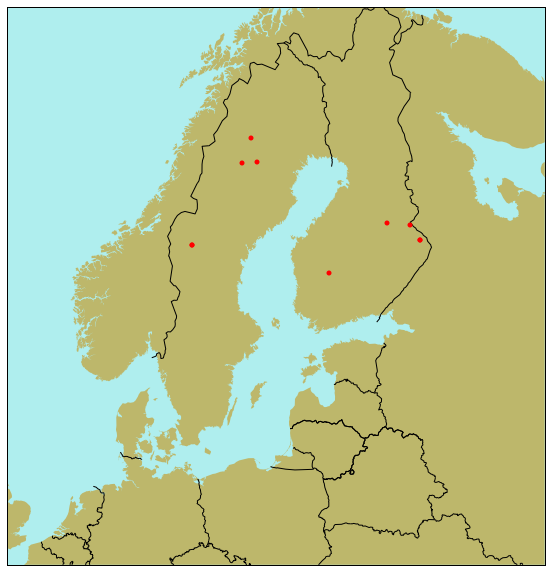

In [12]:
from mpl_toolkits.basemap import Basemap

# Get sites where distance to coast estimates differ by > 100 km
df['diff'] = np.absolute(df['spatialite'] - df['vincenty'])

big_dif = df.query('diff > 75')

big_dif = pd.merge(big_dif, site_df, how='left',
                  left_on='stn_id', right_on='Station ID')

fig = plt.figure(figsize=(10, 10))

# Use a basic Mercator projection
m = Basemap(projection='merc',
            llcrnrlat=50,
            urcrnrlat=70,
            llcrnrlon=0,
            urcrnrlon=40, 
            lat_ts=20, 
            resolution='i')

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Map (long, lat) to (x, y) for plotting
x, y = m(big_dif['Longitude'].values, big_dif['Latitude'].values)

# Plot
plt.plot(x, y, 'or', markersize=5)

The sites with very large errors are mostly located well inland, approximately equidistant from two possible coastlines. The methods used to calculate these distances are numerical (i.e. iterative), so I suspect the differences I'm seeing are associated with convergence of the algorithms, combined with my coarse discretisation of the coastline in the case of Vincenty.

For now, I'll **use the estimates from SpatiaLite**, as these should be more accurate.

### 4.4. Comparison to John's 2006 estimates

In his e-mail from 27/05/2016 at 14:42, John sent me the "distance to coast" dataset he created for the 2006 analysis. It's not easy to match sites between 2006 and 2015, but for those locations with a common site code we can easily compare the three estimates.

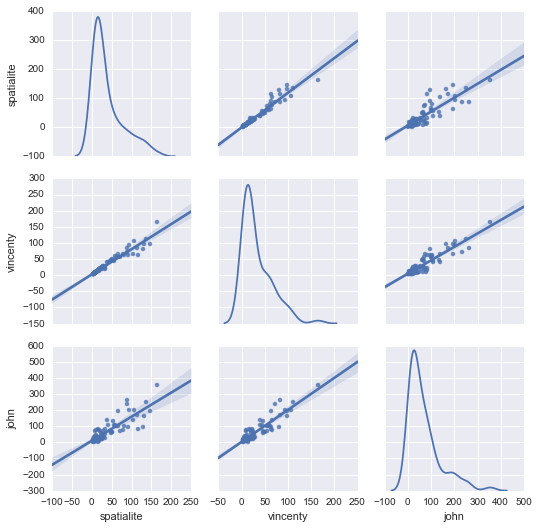

In [30]:
# Read John's distance data
j_dist_path = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W'
               r'\ICP_Waters\TOC_Trends_Analysis_2015\Data\Distance.from.coast.data.from.2006.xlsx')
j_df = pd.read_excel(j_dist_path, sheetname='Sheet1')

# Join to the other estimates
df2 = pd.merge(df, j_df, how='inner',
               left_on='stn_id', right_on='SITE_NO')
df2 = df2[['spatialite', 'vincenty', 'DIST_COAST']]
df2.columns = ['spatialite', 'vincenty', 'john']
df2.dropna(how='any', inplace=True)

# Scatterplot matrix
sn.pairplot(df2, kind='reg', diag_kind='kde')

Unsurprisingly, the distances aren't identical, but they do at least show a clear positive relationship. In general, John's estimates are larger than those from SpatiaLite or Vincenty, which probably reflects the fact that John calculated distances in a *particular direction*, rather than just going for the closest point on the coast as I've done here.

Overall, I think these distance estimates seem reasonable, **add a new site parameter to RESA2 and upload the SpatiaLite values calculated above to the database**.